# Capstone : IT Ticket Classification [SEPT SUN GRP 4B]

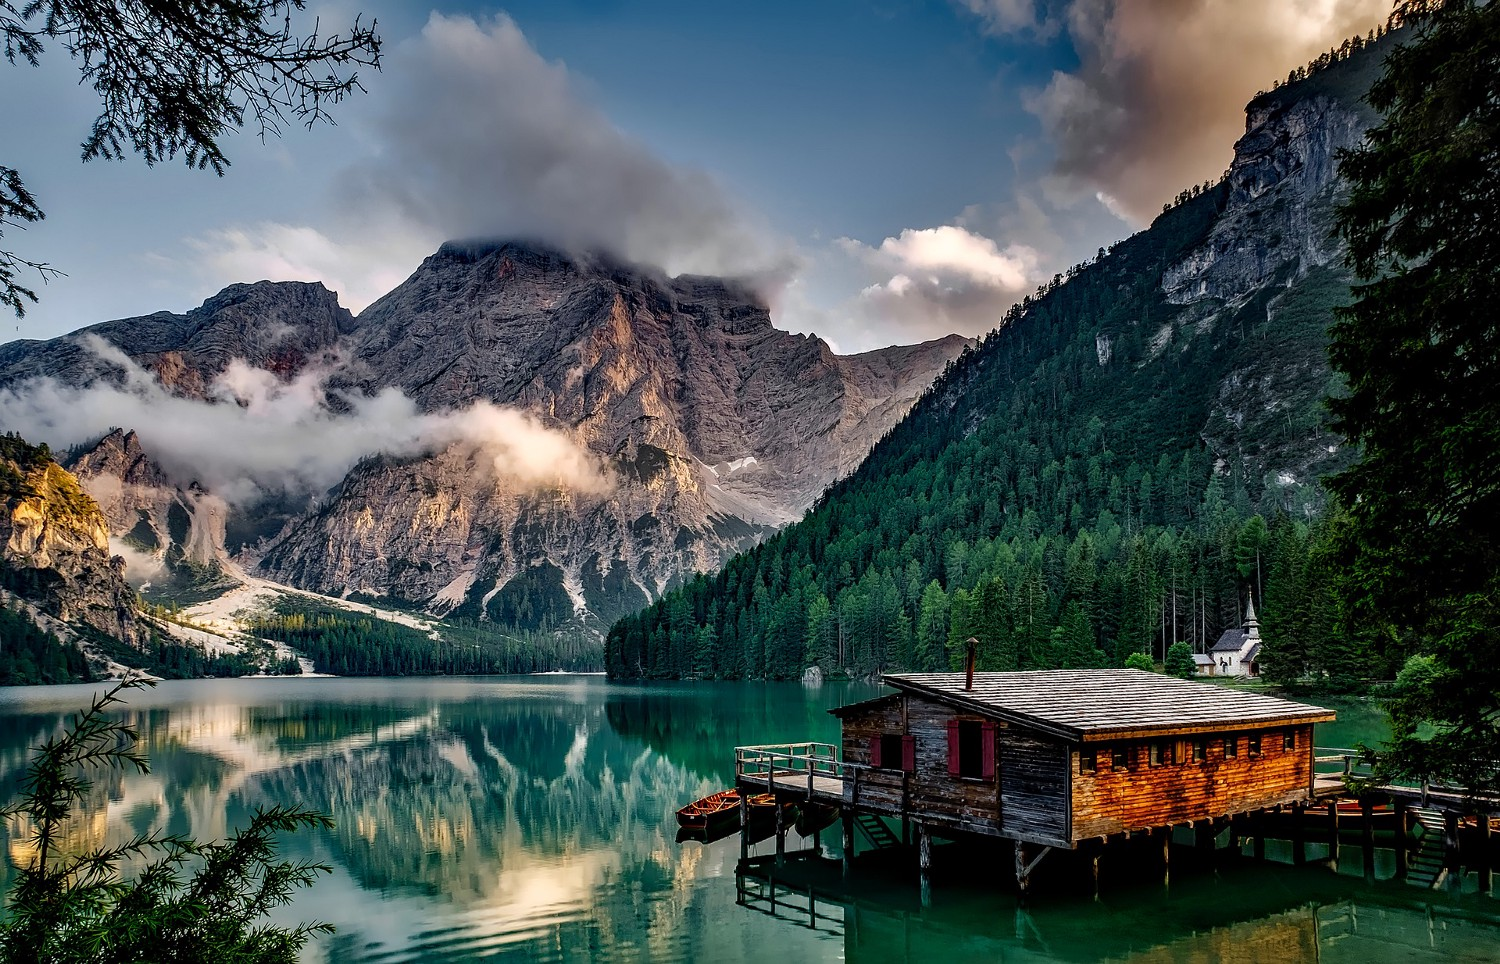

# Aim: Automatic Ticket Assignment [Part 6/6] - HyperParameter Tuning

## Part 6/6: It mainly focuses on HyperParameter Tuning for Machine Learning Models


Build a classifier that can classify the tickets by analyzing text. Classify incidents to right functional groups can help organizations to reduce the resolving time of the issue and can focus on more productive tasks.

# Import Libraries

In [1]:
import pandas as pd 
import numpy as np 
import re 
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import random
import time

import warnings
import pandas.testing as tm
import spacy  
#import langid 
import nltk

import re, string
from wordcloud import WordCloud
from pprint import pprint

from sklearn.utils import resample
from sklearn import preprocessing

from nltk.corpus import stopwords
from nltk.classify.textcat import TextCat  
from dateutil import parser
from nltk.tokenize import word_tokenize
#from langdetect import detect
from textblob import TextBlob
#from googletrans import Translator

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim 

from sklearn.decomposition import LatentDirichletAllocation

from string import punctuation

#import enchant
#from enchant.checker import SpellChecker
    
from sklearn.feature_extraction.text import CountVectorizer
import plotly.express as px

from gensim.models import Word2Vec
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D,GRU,Conv1D,MaxPooling1D
from tensorflow.keras.models import Model, Sequential
import tensorflow as tf
from sklearn import metrics
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from scipy import spatial
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB

import logging, warnings
from PIL import Image
from IPython.display import IFrame

##--------------------##

if sys.version_info >= (3, 3) :
    import collections.abc as collections_abc
else:
    import collections as collections_abc
    
from collections import Counter
from collections import OrderedDict
import operator

##-------------------##

plt.style.use('ggplot')
%matplotlib inline

#warnings.filterwarnings("ignore",category=DeprecationWarning)
#warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [2]:
np.__version__ , pd.__version__,tf.__version__, print(sys.version_info)

sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)


('1.16.1', '1.0.1', '2.0.0', None)

In [3]:
"""
Download required NLTK stopwords corpus if it has not already been downloaded.
Download required NLTK corpora if they have not already been downloaded.
Download the NLTK averaged perceptron tagger that is required for this algorithm to run only if the corpora has not already been downloaded.
Download Punkt Sentence Tokenizer. This tokenizer divides a text into a list of sentences, by using an unsupervised algorithm to build a model for abbreviation words, collocations, and words that start sentences
"""
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True) 

True

# Data Loading

In [5]:
"""
from google.colab import drive
drive.mount('/content/drive')

project_path = '/content/drive/My Drive/Colab Notebooks/'
file_name ='input_data.xlsx'

"""
project_path = 'C:/MyDrive/Drive2/PersonalDrive/MachineLearning/GreatLearning/CapstoneProject/Final-Deck/'
file_name ='input_data.xlsx'

In [6]:
data=pd.read_excel(project_path+file_name,encoding=sys.getfilesystemencoding()) 
data.head()

Short description  \
0                    login issue   
1                        outlook   
2             cant log in to vpn   
3  unable to access hr_tool page   
4                   skype error    

                                         Description             Caller  \
0  -verified user details.(employee# & manager na...  spxjnwir pjlcoqds   
1  \r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...  hmjdrvpb komuaywn   
2  \r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...  eylqgodm ybqkwiam   
3                      unable to access hr_tool page  xbkucsvz gcpydteq   
4                                       skype error   owlgqjme qhcozdfx   

  Assignment group  
0            GRP_0  
1            GRP_0  
2            GRP_0  
3            GRP_0  
4            GRP_0

The performance tuning is done on data which is not resampled. After resampling, we were getting 47K+ records. We tried to run performance
tuning on 47K records for each of the Machine Learning Model on Google Collab as well as on local machine. It was taking lot of time.
As suggested by mentor, we are doing performance tuning for the models on the unsampled records it self.

# Data Duplication (Description & Assignment Group Criterion)

In [7]:
data = data.drop_duplicates(subset=[data.columns[1], data.columns[3]], keep='first')

In [8]:
data.shape

(7839, 4)

# Missing & Modal Values

In [9]:
data[data.columns[0]].fillna(value=' ', inplace=True)

In [10]:
data[data.columns[1]].fillna(value=' ', inplace=True)

In [11]:
len(data[data.columns[3]].unique())

74

# New Column (New Assignment Group)

### Regrouping the class having less than 10 records into one group as suggested earlier as a recommendation to reduce the groups where there are less tickets available.

In [12]:
m_i_cnt=10 #Minimum Incidents Crieria For To Be An Independent Class Else Aggregate
s_a_grps=[]
for i in data[data.columns[3]].unique():
    if(data.groupby(data.columns[3])[data.columns[3]].value_counts()[i][0]<m_i_cnt):
        s_a_grps.append(i)

Groups Having Number of Incident Frequency less than threshold criteri of 10 incidents per group


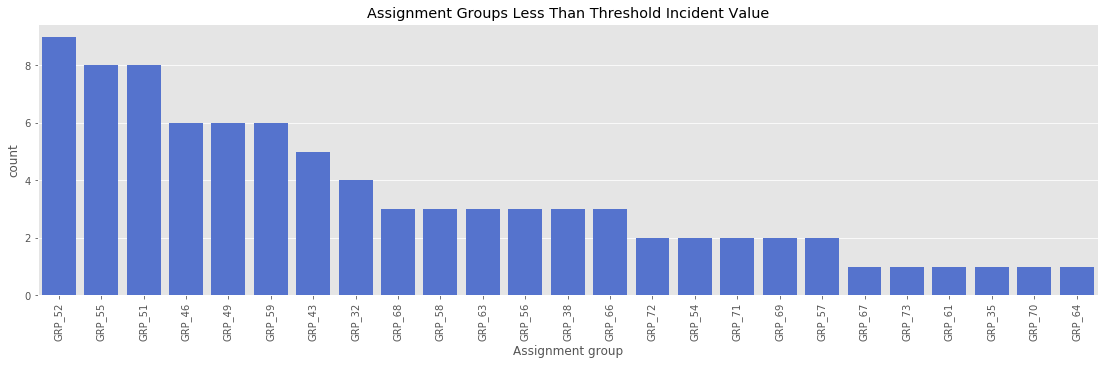

In [13]:
print('Groups Having Number of Incident Frequency less than threshold criteri of {} incidents per group'.format(m_i_cnt))
if len(s_a_grps) >0:
    plt.subplots(figsize=(19,5))
    ax=sns.countplot(x=data[ data[data.columns[3]].isin( s_a_grps )].columns[3], 
                 data=data[ data[data.columns[3]].isin( s_a_grps ) ], 
                 color='royalblue',
                 order= data[ data[data.columns[3]].isin( s_a_grps ) ][data[ data[data.columns[3]].isin( s_a_grps ) ].columns[3]].value_counts().sort_values(ascending=False).index
                )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
    ax.set_title('Assignment Groups Less Than Threshold Incident Value')
    plt.show()

In [14]:
print('Regrouping {} assignment groups under a new group which have incident frequency under minimum count of {}'.format(len(s_a_grps), m_i_cnt))

Regrouping 25 assignment groups under a new group which have incident frequency under minimum count of 10


In [15]:
data['New_Assignment_Groups'] = data[data.columns[3]]

In [16]:
data[data.columns[4]] = data[data.columns[4]].apply(lambda x : 'GRP_M_I_CNT' if x in s_a_grps else x)

In [17]:
data.shape

(7839, 5)

# New Column (Text Length)

In [18]:
data['Text_length']=[len(text) for text in data[data.columns[1]]]
data.head(2).T

0  \
Short description                                            login issue   
Description            -verified user details.(employee# & manager na...   
Caller                                                 spxjnwir pjlcoqds   
Assignment group                                                   GRP_0   
New_Assignment_Groups                                              GRP_0   
Text_length                                                          206   

                                                                       1  
Short description                                                outlook  
Description            \r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...  
Caller                                                 hmjdrvpb komuaywn  
Assignment group                                                   GRP_0  
New_Assignment_Groups                                              GRP_0  
Text_length                                                          194

# Combining Short Description and Description

## Combining short description and description column into one for further processing

In [19]:
data.reset_index(drop=True,inplace=True)

In [20]:
data['Description'] = data['Short description'].str.cat(data['Description'], sep=' ', na_rep=' ')

In [21]:
data.head(2).T

0  \
Short description                                            login issue   
Description            login issue -verified user details.(employee# ...   
Caller                                                 spxjnwir pjlcoqds   
Assignment group                                                   GRP_0   
New_Assignment_Groups                                              GRP_0   
Text_length                                                          206   

                                                                       1  
Short description                                                outlook  
Description            outlook \r\n\r\nreceived from: hmjdrvpb.komuay...  
Caller                                                 hmjdrvpb komuaywn  
Assignment group                                                   GRP_0  
New_Assignment_Groups                                              GRP_0  
Text_length                                                          194

# Cleaning Data

In [22]:
def is_valid_date(date_str):
    try:
        parser.parse(date_str)
        return True
    except:
        return False

In [23]:
def clean_data(text):
    text = text.lower()
    #text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = ' '.join([w for w in text.split() if not is_valid_date(w)])
    text = re.sub(r"received from:",' ',text)
    text = re.sub(r"from:",' ',text)
    text = re.sub(r"to:",' ',text)
    text = re.sub(r"subject:",' ',text)
    text = re.sub(r"sent:",' ',text)
    text = re.sub(r"ic:",' ',text)
    text = re.sub(r"cc:",' ',text)
    text = re.sub(r"bcc:",' ',text)
    text = re.sub(r'\S*@\S*\s?', '', text)#Remove email 
    text = re.sub(r'\d+','' ,text) # \d is the same as [0-9] single digit & \d+ means all sequential digits i.e. removes digits
    text = re.sub(r'\n',' ',text) # Remove new line characters 
    text = re.sub(r'\t',' ',text) 
    text = re.sub(r'#','', text)  # Remove hashtag while keeping hashtag text
    text = re.sub(r'&;?', 'and',text)  #& 
    text = re.sub(r'https?:\/\/.*\/\w*', '', text)   # Remove hyperlinks
    #text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL', text)
    text= ''.join(c for c in text if c <= '\uFFFF') # Remove characters beyond Readable formart by Unicode:
    text = text.strip() # Remove unreadable characters  (also extra spaces)
    text = ' '.join(re.sub("[^\u4e00-\u9fa5\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", text).split())
    for callers in data[data.columns[2]]:   # get all the caller names from the column and remove these names from the description wherever a match is found.
        callerslist = [name for name in callers.split()]
        for anynamepart in callerslist: 
            text = text.replace(anynamepart,'')
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.strip()
    return text

In [24]:
start = time.time()
data[data.columns[1]]=data[data.columns[1]].apply(clean_data)
time.sleep(1)
end = time.time()
print(f"Time Taken To Clean Data : {end - start}")
data.shape

Time Taken To Clean Data : 89.51907086372375


(7839, 6)

# Stopwords & Lemmatisation

In [25]:
# from nltk.corpus import stopwords
stop_words = stopwords.words('english') # NLTK Stop words

In [26]:
start = time.time()
for i,text in enumerate(data[data.columns[1]]):
    data[data.columns[1]][i]=" ".join(w for w in text.split(' ') if w not in stop_words)
time.sleep(1)
end = time.time()

print(f"Time Taken To Remove Stop Words From Data : {end - start}")

Time Taken To Remove Stop Words From Data : 2.300081253051758


In [28]:
nlp = spacy.load('en', disable=['parser', 'ner'])
allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']


def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])


start = time.time()
data[data.columns[1]] = data[data.columns[1]].apply(lemmatize_text)
time.sleep(1)
end = time.time()
print(f"Time Taken To Lemmatise Data : {end - start}")

data.shape

Time Taken To Lemmatise Data : 25.597490072250366


(7839, 6)

# Label Encoding

In [29]:
def labelencoder(dataframe) : 
    label_encoder = preprocessing.LabelEncoder() 
    dataframe = label_encoder.fit_transform(dataframe)
    encodedlabels = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
    return dataframe, encodedlabels

In [30]:
data[data.columns[4]], data_labels = labelencoder(data[data.columns[4]])

In [36]:
data.to_csv(project_path+"itsupportdatacleaned_hp.csv" , index=False)
#data.to_excel("itsupportdatacleaned.xlsx" , index=False)

# Modeling

In [32]:
#data=pd.read_csv(project_path+'itsupportdatacleaned_np.csv',encoding=sys.getfilesystemencoding()) 
#data.dropna(subset=[data.columns[1]], inplace=True)

In [37]:
data_hp = data.copy()

In [38]:
def wordTokenizer(dataframe):
    tokenizer = Tokenizer(num_words=numWords,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=' ', char_level=False)
    tokenizer.fit_on_texts(dataframe)
    dataframe = tokenizer.texts_to_sequences(dataframe)
    return tokenizer,dataframe

In [39]:
data_hp.reset_index(drop=True, inplace=True)

data_hp.columns[1],data_hp.columns[4]

maxlen = 150
numWords = 9000

# Random Forest Classifier (Without resampling)

In [40]:
tokenizer,X = wordTokenizer(data_hp[data_hp.columns[1]])

y = np.asarray(data_hp[data_hp.columns[4]])
X = pad_sequences(X, maxlen = maxlen)

print("Number of Samples:", len(X))
print("Number of Labels: ", len(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)


print("Number of Training Samples:", len(X_train))
print("Number of Validation Samples:", len(X_test))

data_hp_RFC = RandomForestClassifier(n_estimators=100)

start = time.time()
data_hp_RFC.fit(X_train,y_train)
time.sleep(1)
end = time.time()
print(f"Time Taken To Train RFC on dataset 3 : {end - start}")

y_pred=data_hp_RFC.predict(X_test)
train_acc = data_hp_RFC.score(X_train,y_train)
print("Training Accuracy:",train_acc)
test_acc = metrics.accuracy_score(y_test, y_pred)
print("Test Accuracy:",test_acc)


results_HP_ML_Models = pd.DataFrame()
results_data_RFC = pd.DataFrame({'Model':['Random Forest'], 'Train accuracy': [train_acc], 'Test accuracy': [test_acc]},index={'1'})
results_HP_ML_Models = pd.concat([results_HP_ML_Models, results_data_RFC])
results_HP_ML_Models

Number of Samples: 7839
Number of Labels:  7839
Number of Training Samples: 6271
Number of Validation Samples: 1568
Time Taken To Train RFC on dataset 3 : 3.9492239952087402
Training Accuracy: 0.9467389571041301
Test Accuracy: 0.5478316326530612


Model  Train accuracy  Test accuracy
1  Random Forest        0.946739       0.547832

Since testing accurary is very less than training accuracy. The model is overfitting. regularization is applied in the processing scripts.

# Random Forest Classifier (KFold Crossvalidation)

In [ ]:
KFold cross validation is done since target classes are imbalanced. 

In [41]:
from sklearn.model_selection import KFold, cross_val_score

tokenizer,X = wordTokenizer(data_hp[data_hp.columns[1]])

y = np.asarray(data_hp[data_hp.columns[4]])
X = pad_sequences(X, maxlen = maxlen)

print("Number of Samples:", len(X))
print("Number of Labels: ", len(y))

data_hp_RFC = RandomForestClassifier(n_estimators=100)

#Apply K Fold cross validation
start = time.time()
kfold = KFold(n_splits=10, random_state=101)
kfold_results = cross_val_score(data_hp_RFC,X, y, cv=kfold)
end = time.time()
print(f"Time Taken To Train RFC on dataset 3 : {end - start}")

kfold_accuracy = np.mean(abs(kfold_results))
print('KFold Average accuracy: ',kfold_accuracy)

results_data_kf_RFC = pd.DataFrame({'Model':['Random Forest[KFold]'], 'Test accuracy': [kfold_accuracy]},index={'1'})
results_HP_ML_Models = pd.concat([results_HP_ML_Models, results_data_kf_RFC])
results_HP_ML_Models

Number of Samples: 7839
Number of Labels:  7839
Time Taken To Train RFC on dataset 3 : 35.8132209777832
KFold Average accuracy:  0.5475146284567467


Model  Train accuracy  Test accuracy
1         Random Forest        0.946739       0.547832
1  Random Forest[KFold]             NaN       0.547515

# Random Forest Classifier (StratifiedKFold)

Stratified KFold is used since class is highly imbalanced. Using this technique is useful for multi class imbalanced dataset.

In [42]:
tokenizer,X = wordTokenizer(data_hp[data_hp.columns[1]])

y = np.asarray(data_hp[data_hp.columns[4]])
X = pad_sequences(X, maxlen = maxlen)

print("Number of Samples:", len(X))
print("Number of Labels: ", len(y))

from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc

kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=101)
cv_score =[]
i=1

for train_index,test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    X_train, X_test = X[train_index],X[test_index]
    y_train, y_test = y[train_index],y[test_index]
    
    data_hp_RFC = RandomForestClassifier(n_estimators=100)
    data_hp_RFC.fit(X_train,y_train)
    y_pred = data_hp_RFC.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print("Accuracy:",accuracy)
    cv_score.append(accuracy) 
    i+=1

mean_accuracy = np.mean(cv_score)
print('StratifiedKFold Average accuracy',mean_accuracy)
results_data_skf_RFC = pd.DataFrame({'Model':['Random Forest[Stratified KFold]'], 'Test accuracy': [mean_accuracy]},index={'1'})
results_HP_ML_Models = pd.concat([results_HP_ML_Models, results_data_skf_RFC])
results_HP_ML_Models

Number of Samples: 7839
Number of Labels:  7839
1 of KFold 10
Accuracy: 0.5497448979591837
2 of KFold 10
Accuracy: 0.5459183673469388
3 of KFold 10
Accuracy: 0.5650510204081632
4 of KFold 10
Accuracy: 0.548469387755102
5 of KFold 10
Accuracy: 0.5510204081632653
6 of KFold 10
Accuracy: 0.5510204081632653
7 of KFold 10
Accuracy: 0.5625
8 of KFold 10
Accuracy: 0.5522959183673469
9 of KFold 10
Accuracy: 0.5586734693877551
10 of KFold 10
Accuracy: 0.5721583652618135
StratifiedKFold Average accuracy 0.5556852242812834


Model  Train accuracy  Test accuracy
1                    Random Forest        0.946739       0.547832
1             Random Forest[KFold]             NaN       0.547515
1  Random Forest[Stratified KFold]             NaN       0.555685

# Random Forest Classifier (HyperParameter tuned via GridSearch)

In [43]:
tokenizer,X = wordTokenizer(data_hp[data_hp.columns[1]])

y = np.asarray(data_hp[data_hp.columns[4]])
X = pad_sequences(X, maxlen = maxlen)

print("Number of Samples:", len(X))
print("Number of Labels: ", len(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)


print("Number of Training Samples:", len(X_train))
print("Number of Validation Samples:", len(X_test))

rforest = RandomForestClassifier()

n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

start = time.time()
gridF = GridSearchCV(rforest, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)
print(f"Time Taken To Get Best Parameters For FRC on dataset 3 with Grid Search: {end - start}")

print(bestF.best_params_)

Number of Samples: 7839
Number of Labels:  7839
Number of Training Samples: 6271
Number of Validation Samples: 1568
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 29.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 52.1min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 64.1min finished


Time Taken To Get Best Parameters For FRC on dataset 3 with Grid Search: -914.1758856773376
{'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}


In [38]:
#data_hp_RFC = RandomForestClassifier(**bestF.best_params_)
data_hp_RFC = RandomForestClassifier(max_depth= 30, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 300)

start = time.time()
data_hp_RFC.fit(X_train,y_train)
time.sleep(1)
end = time.time()
print(f"Time Taken To Train RFC on dataset 3 : {end - start}")

y_pred=data_hp_RFC.predict(X_test)
train_acc = data_hp_RFC.score(X_train,y_train)
print("Training Accuracy:",train_acc)
test_acc = metrics.accuracy_score(y_test, y_pred)
print("Test Accuracy:",test_acc)


results_data_RFC = pd.DataFrame({'Model':['Random Forest[HP]'], 'Train accuracy':[train_acc], 'Test accuracy': [test_acc]},index={'1'})
results_HP_ML_Models = pd.concat([results_HP_ML_Models, results_data_RFC])
results_HP_ML_Models

Time Taken To Train RFC on dataset 3 : 9.47234058380127
Training Accuracy: 0.9437358276643991
Test Accuracy: 0.5708812260536399


Model  Test accuracy  Train accuracy
1                    Random Forest       0.547194        0.946739
1             Random Forest[KFold]       0.548917             NaN
1  Random Forest[Stratified KFold]       0.554409             NaN
1                Random Forest[HP]       0.570881        0.943736

So we see even with hyperParameter tuned RandomForest Classifier using GridSeach and Stratified KFold on the 
original dataset(with resampling) is giving a maximum accuracy of around 57%. Hence we should go with up-sampling of the 
data where we are seeing the accuracy around 95% 

# DecisionTree (considering cost_complexity_pruning_path) [OPTIONAL]

In [50]:
tokenizer,X = wordTokenizer(data_hp[data_hp.columns[1]])

y = np.asarray(data_hp[data_hp.columns[4]])
X = pad_sequences(X, maxlen = maxlen)

print("Number of Samples:", len(X))
print("Number of Labels: ", len(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)


print("Number of Training Samples:", len(X_train))
print("Number of Validation Samples:", len(X_test))

data_hp_DC = DecisionTreeClassifier(random_state=101)

start = time.time()
data_hp_DC.fit(X_train,y_train)
time.sleep(1)
end = time.time()
print(f"Time Taken To Train DT on dataset 3 : {end - start}")

y_pred=data_hp_DC.predict(X_test)
train_acc = data_hp_DC.score(X_train,y_train)
print("Training Accuracy:",train_acc)
test_acc = metrics.accuracy_score(y_test, y_pred)
print("Test Accuracy:",test_acc)


results_data_RFC = pd.DataFrame({'Model':['Decision Tree'], 'Train accuracy':[train_acc], 'Test accuracy': [test_acc]},index={'1'})
results_HP_ML_Models = pd.concat([results_HP_ML_Models, results_data_RFC])
results_HP_ML_Models

Number of Samples: 7839
Number of Labels:  7839
Number of Training Samples: 6271
Number of Validation Samples: 1568
Time Taken To Train DT on dataset 3 : 1.3090081214904785
Training Accuracy: 0.9467389571041301
Test Accuracy: 0.41581632653061223


Model  Test accuracy  Train accuracy
1                    Random Forest       0.547194        0.946739
1             Random Forest[KFold]       0.548917             NaN
1  Random Forest[Stratified KFold]       0.554409             NaN
1                Random Forest[HP]       0.570881        0.943736
1                Decision Tree[HP]       0.478954        0.478552
1                    Decision Tree       0.415816        0.946739

Since Decision tree is overfitting, we will try to consider cost_complexity_pruning_path

In [39]:
import sklearn as sklearn
sklearn.__version__

'0.22.1'

In [42]:
from sklearn.tree import DecisionTreeClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

start = time.time()
clf = DecisionTreeClassifier(random_state=101)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
end = time.time()
print(f"Time Taken To run cost complexity pruning : {end - start}")

Time Taken To run cost complexity pruning : 0.3470020294189453


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

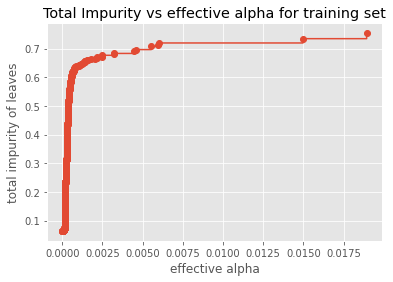

In [43]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [44]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=101, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.0399012813600651


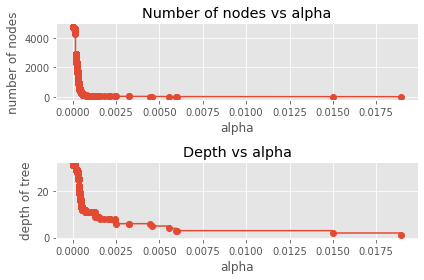

In [45]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

In [51]:
tokenizer,X = wordTokenizer(data_hp[data_hp.columns[1]])

y = np.asarray(data_hp[data_hp.columns[4]])
X = pad_sequences(X, maxlen = maxlen)

print("Number of Samples:", len(X))
print("Number of Labels: ", len(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)


print("Number of Training Samples:", len(X_train))
print("Number of Validation Samples:", len(X_test))

data_hp_DC = DecisionTreeClassifier(random_state=101, ccp_alpha= 0.0399)

start = time.time()
data_hp_DC.fit(X_train,y_train)
time.sleep(1)
end = time.time()
print(f"Time Taken To Train DT on dataset 3 : {end - start}")

y_pred=data_hp_DC.predict(X_test)
train_acc = data_hp_DC.score(X_train,y_train)
print("Training Accuracy:",train_acc)
test_acc = metrics.accuracy_score(y_test, y_pred)
print("Test Accuracy:",test_acc)


results_data_RFC = pd.DataFrame({'Model':['Decision Tree[HP]'], 'Train accuracy':[train_acc], 'Test accuracy': [test_acc]},index={'1'})
results_HP_ML_Models = pd.concat([results_HP_ML_Models, results_data_RFC])
results_HP_ML_Models

Number of Samples: 7839
Number of Labels:  7839
Number of Training Samples: 6271
Number of Validation Samples: 1568
Time Taken To Train DT on dataset 3 : 1.3434321880340576
Training Accuracy: 0.4785520650613937
Test Accuracy: 0.4789540816326531


Model  Test accuracy  Train accuracy
1                    Random Forest       0.547194        0.946739
1             Random Forest[KFold]       0.548917             NaN
1  Random Forest[Stratified KFold]       0.554409             NaN
1                Random Forest[HP]       0.570881        0.943736
1                Decision Tree[HP]       0.478954        0.478552
1                    Decision Tree       0.415816        0.946739
1                Decision Tree[HP]       0.478954        0.478552

## Summary:
In part 5/6, we have resampled the records.Total number of records were 46991 records.Random forest performed well as compared to other Machine Learning models.Hence, Performance tuning is performed only for Random Forest Model.

Google collab and on local machine, performance tuning was taking all the resources for sampled records (46991). Hence, it was decided to do performance tuning on unsampled data. Since dataset has higly imbalanced class frequencies, it was suggested to group the class having less than 10 incidents into one class. This is to recommend that the number of groups can be reduced and clubbed into one group.

The Random forest classifier is implemented on unsampled data (with 50 classes, less than ten incident classes clubbed into one group).
KFold cross validation is implemented. Stratified Kfold validation is also performed since class was imbalanced. 

Performance tuning using GridSearch to find the best parameters. Additionally, desicion tree classifier with cost_complexity_pruning_path is also explored to validate if it can assist with improving accuracy further and reducing overfitting of the models.

The accuracies for all the approaches tried are given above. In addition, the report can be referrenced for detailed information. 

We can see that even with hyperParameter tuned RandomForest Classifier using GridSeach and Stratified KFold on the 
original dataset(with resampling) is giving a maximum accuracy of around 57%. Hence we should go with up-sampling of the 
data where we are seeing the accuracy around 95% 



In addition, detailed information and analysis for each of the parts from 1 to 6 and on BERT implemention can be referenced from the report submitted with the solution. Along with detailed analysis information, furure recommenations, our findings and understandings are in the report.
